In [164]:
import copy
import networkx as nx
from ete3 import Tree
from cassiopeia.data import CassiopeiaTree
from cassiopeia.tools import small_parsimony as sp
import pandas as pd


# for each tree:
# read in tree
# exclude if leaves all in same tumor
# infer metastasis labels, without adding new nodes
# new tree has node labels of loc.name
# use inferred labels to resolve polytomies by adding new nodes
# write resolved tree to new file in newick format (same as input file)
# compute metastasis score for initial tree and resolved tree
    # number of edges where metastsis occurs / total number of edges (use original number of edges for resolved tree)

def compute_met_score(tree: CassiopeiaTree, resolved_tree: CassiopeiaTree = None) -> float:
    # compute metastasis score
    met_edges = 0
    total_edges = len(tree.edges)

    for node in tree.nodes:
        # check if there is a metastasis event between node and children
        if tree.is_leaf(node):
            continue
        
        try:
            node_location = tree.get_attribute(node, 'met_location')
        except:
            node_location = node.split('.')[0]
        
        children = tree.children(node)
        if resolved_tree is not None:
            children = resolved_tree.children(node)

        for child in children:
            try:
                child_location = tree.get_attribute(child, 'met_location')
            except:
                child_location = child.split('.')[0]
            
            if node_location != child_location:
                met_edges += 1

    return met_edges / total_edges

def resolve_polytomies(tree: CassiopeiaTree, editable_tree: Tree) -> CassiopeiaTree:
    for node in tree.nodes:
        # check if there is a metastasis event between node and children
        if tree.is_leaf(node) or len(tree.children(node)) <= 2:
            continue
        
        node_location = tree.get_attribute(node, 'met_location')

        met_nodes = {key: [] for key in ["LL", "RE", "RW", "M1", "M2", "Liv"] if key != node_location}
        
        for child in tree.children(node):
            child_location = tree.get_attribute(child, 'met_location')
            if node_location != child_location:
                met_nodes[child_location].append(child)
        tree_node:Tree = editable_tree.search_nodes(name=node)[0]
        for key in met_nodes:
            if len(met_nodes[key]) > 1:
                poly_resolve_node = tree_node.add_child(name=f'{key}.{node}')
                # children = tree_node.children.copy()
                for child in met_nodes[key]:
                    child_node = tree_node.search_nodes(name=child)[0].detach()
                    poly_resolve_node.add_child(child_node)
                    # poly_resolve_node.add_child(copy.deepcopy(child_node))
                    # tree_node.remove_child(child_node)
                # poly_resolve_node = tree_node.add_child(name=f'{key}.{node.name}')
    resolved_tree = CassiopeiaTree(tree=editable_tree, cell_meta=tree.cell_meta)
    return resolved_tree

            

origin_tumor = 'LL'

scores = {}

trees = {}

for clonal_population in range(1,101):
    # read in tree from file
    try:
        with open(f'GSE161363_RAW/trees/m5k_lg{clonal_population}_tree_hybrid_priors.alleleThresh.processed.txt', 'r') as f:
            newick_str = f.read().strip()
    except FileNotFoundError:
        try:
            with open(f'GSE161363_RAW/trees/m5k_lg{clonal_population}_tree_greedy_priors.alleleThresh.processed.txt', 'r') as f:
                newick_str = f.read().strip()
        except FileNotFoundError:
            print(f'File not found: GSE161363_RAW/trees/m5k_lg{clonal_population}_tree_hybrid_priors.alleleThresh.processed.txt')
            continue

    try:

        t = Tree(newick_str, format=1)

        # handle duplicate node names
        count = 0
        all_nodes_already_in_tree = set()
        # iterate through trees and rename edges
        for node in t.traverse():
            if node.name in all_nodes_already_in_tree:
                node.name = f"{node.name}_{count}"
                count += 1
            all_nodes_already_in_tree.add(node.name)

        # convert to CassiopeiaTree

        leaves = [node.name for node in t.get_leaves()]

        cell_met_labels = [leaf.split('.')[0] for leaf in leaves]

        cell_meta_data = pd.DataFrame({'met_labels': cell_met_labels}, index=leaves).astype("category")

        cass_tree = CassiopeiaTree(tree=t, cell_meta=cell_meta_data)

        # compute metastasis labels

        fitch_tree = sp.fitch_hartigan(cass_tree, meta_item='met_labels', label_key='met_location', copy=True)

        resolved_tree = resolve_polytomies(fitch_tree, t)

        # compute scores

        original_met_score = compute_met_score(fitch_tree)

        resolved_met_score = compute_met_score(fitch_tree, resolved_tree)

        scores[clonal_population] = (original_met_score, resolved_met_score)

        trees[clonal_population] = (fitch_tree, resolved_tree)

        # print to file

        # with open(f'resolvedtrees/m5k_lg{clonal_population}_tree_hybrid_priors.alleleThresh.processed_resolved.txt', 'w+') as f:
        #     f.write(resolved_tree.get_newick())
    except Exception as e:
        print(f"{e} in {clonal_population}")
        # with open(f'resolvedtrees/error.txt', 'a+') as f:
        #     f.write(str(e)+'\n')
    print(f"Finished {clonal_population}")
    
# with open(f'resolvedtrees/score.txt', 'w+') as f:
#     f.write(str(scores))

Finished 1
Finished 2
Finished 3
Finished 4
File not found: GSE161363_RAW/trees/m5k_lg5_tree_hybrid_priors.alleleThresh.processed.txt
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
File not found: GSE161363_RAW/trees/m5k_lg16_tree_hybrid_priors.alleleThresh.processed.txt
Finished 17
File not found: GSE161363_RAW/trees/m5k_lg18_tree_hybrid_priors.alleleThresh.processed.txt
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
File not found: GSE161363_RAW/trees/m5k_lg25_tree_hybrid_priors.alleleThresh.processed.txt
Finished 26
Finished 27
Finished 28
Finished 29
Finished 30
Finished 31
Finished 32
File not found: GSE161363_RAW/trees/m5k_lg33_tree_hybrid_priors.alleleThresh.processed.txt
Finished 34
Finished 35
Finished 36
Finished 37
File not found: GSE161363_RAW/trees/m5k_lg38_tree_hybrid_priors.alleleThresh.processed.txt
File not found: GSE161363_RAW/trees/m5k_lg39_tree_hybrid_priors.alleleThresh.pr

In [165]:
scores

{1: (0.1685459940652819, 0.12181998021760633),
 2: (0.11552467456364321, 0.10409777740571763),
 3: (0.005871725383920506, 0.0058215396968784505),
 4: (0.05845442536327609, 0.05250990752972259),
 6: (0.050955414012738856, 0.048407643312101914),
 7: (0.048975957257346395, 0.040516473731077474),
 8: (0.15855572998430142, 0.15018315018315018),
 9: (0.13983286908077994, 0.13147632311977717),
 10: (0.08728179551122195, 0.06234413965087282),
 11: (0.06693711967545639, 0.0654158215010142),
 12: (0.041796631316281974, 0.041796631316281974),
 13: (0.10972143263217737, 0.10403638430926662),
 14: (0.04357798165137615, 0.04357798165137615),
 15: (0.06915544675642595, 0.06609547123623011),
 17: (0.11532125205930807, 0.10378912685337727),
 19: (0.029531568228105907, 0.0274949083503055),
 20: (0.03919372900335946, 0.0335946248600224),
 21: (0.07817969661610269, 0.073512252042007),
 22: (0.0, 0.0),
 23: (0.03383458646616541, 0.03258145363408521),
 24: (0.125, 0.12042682926829268),
 26: (0.1544502617801

In [140]:
len(trees[1][0].nodes)

25276

In [141]:
len(trees[1][1].nodes)

25671

In [166]:
score_diff = [[key, val[0] - val[1], ((val[0] - val[1])/(max(val[0], 0.0000000001)))] for key, val in scores.items() if val[0] != 0.0]

In [143]:
scores

{1: (0.1685459940652819, 0.13072205736894163),
 2: (0.11552467456364321, 0.10598133188229877),
 3: (0.005871725383920506, 0.0058215396968784505),
 4: (0.05845442536327609, 0.052840158520475564),
 6: (0.050955414012738856, 0.048407643312101914),
 7: (0.048975957257346395, 0.04407836153161175),
 8: (0.15855572998430142, 0.15018315018315018),
 9: (0.13983286908077994, 0.13760445682451253),
 10: (0.08728179551122195, 0.0798004987531172),
 11: (0.06693711967545639, 0.0654158215010142),
 12: (0.041796631316281974, 0.041796631316281974),
 13: (0.10972143263217737, 0.10517339397384878),
 14: (0.04357798165137615, 0.04357798165137615),
 15: (0.06915544675642595, 0.06609547123623011),
 17: (0.11532125205930807, 0.11037891268533773),
 19: (0.029531568228105907, 0.0274949083503055),
 20: (0.03919372900335946, 0.03471444568868981),
 21: (0.07817969661610269, 0.073512252042007),
 22: (0.0, 0.0),
 23: (0.03383458646616541, 0.03258145363408521),
 24: (0.125, 0.12042682926829268),
 26: (0.1544502617801

In [191]:
init_scores = [[key, val[0]] for key, val in scores.items() if val[0] != 0.0]
final_scores = [[key, val[1]] for key, val in scores.items() if val[0] != 0.0]

In [192]:
import numpy as np
argsorted_init = np.array(init_scores)[:,1].argsort()
argsorted_resolved = np.array(final_scores)[:,1].argsort()
ranks_init = [init_scores[i][0] for i in argsorted_init]
ranks_resolved = [final_scores[i][0] for i in argsorted_resolved]

In [206]:
len(ranks_init)

75

In [194]:
ranks_resolved

[27,
 57,
 3,
 67,
 48,
 47,
 49,
 19,
 63,
 72,
 35,
 79,
 45,
 23,
 20,
 44,
 89,
 42,
 7,
 36,
 80,
 32,
 12,
 34,
 31,
 14,
 70,
 58,
 6,
 76,
 60,
 92,
 95,
 4,
 43,
 86,
 52,
 73,
 100,
 10,
 82,
 11,
 15,
 99,
 21,
 51,
 40,
 97,
 84,
 28,
 83,
 91,
 74,
 98,
 64,
 71,
 56,
 62,
 61,
 17,
 13,
 2,
 68,
 24,
 37,
 30,
 1,
 26,
 90,
 9,
 59,
 54,
 77,
 8,
 66]

In [195]:
print(ranks_init)
rank_change = [ranks_resolved.index(rank) - ranks_init.index(rank) for rank in ranks_init]
print(rank_change)

[27, 57, 3, 67, 48, 47, 49, 63, 72, 19, 79, 35, 23, 45, 44, 89, 42, 20, 36, 80, 12, 14, 70, 31, 58, 34, 7, 76, 60, 6, 92, 95, 32, 43, 4, 86, 73, 100, 11, 15, 99, 82, 97, 40, 21, 51, 52, 83, 28, 91, 98, 84, 71, 10, 74, 56, 64, 61, 62, 13, 17, 2, 68, 24, 30, 59, 77, 37, 54, 9, 90, 26, 8, 66, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 1, -2, 1, -1, 1, -1, 1, 1, 1, -3, 1, 1, 2, 4, 4, 1, 3, -2, -8, 2, 2, -1, 1, 1, -11, 1, -1, 0, 1, 1, 3, 3, 3, -1, 5, 3, 0, 0, -10, 3, 1, 2, 3, -3, 3, -14, -2, 1, -2, 1, -1, 1, -1, 0, 0, 0, 1, 5, 6, -3, 3, 0, -2, -4, 1, 1, -8]


<BarContainer object of 75 artists>

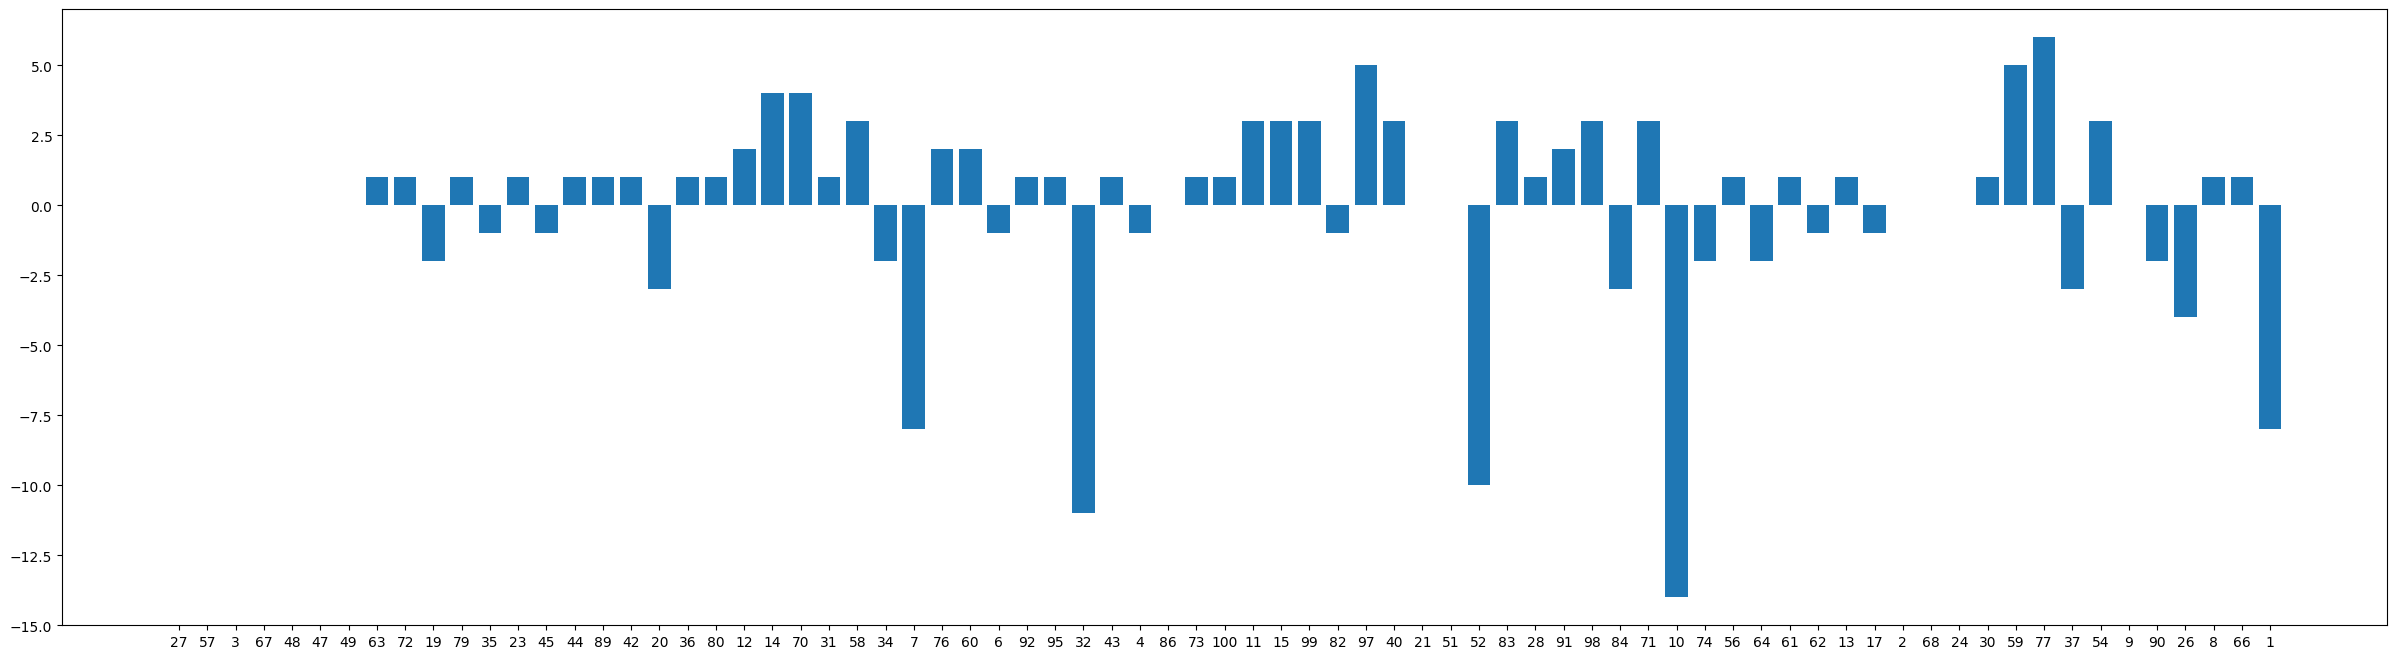

In [211]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(30, 8))

ax1.bar([f"{rank}" for rank in ranks_init], rank_change)

In [167]:
score_diff

[[1, 0.046726013847675565, 0.2772300469483568],
 [2, 0.01142689715792558, 0.0989130434782609],
 [3, 5.0185687042055525e-05, 0.008547008547008532],
 [4, 0.0059445178335535, 0.1016949152542373],
 [6, 0.002547770700636942, 0.04999999999999999],
 [7, 0.008459483526268921, 0.1727272727272727],
 [8, 0.008372579801151248, 0.05280528052805292],
 [9, 0.00835654596100277, 0.059760956175298696],
 [10, 0.02493765586034913, 0.2857142857142857],
 [11, 0.0015212981744421872, 0.022727272727272676],
 [12, 0.0, 0.0],
 [13, 0.005685048322910752, 0.05181347150259074],
 [14, 0.0, 0.0],
 [15, 0.0030599755201958373, 0.044247787610619455],
 [17, 0.011532125205930804, 0.09999999999999998],
 [19, 0.0020366598778004084, 0.06896551724137935],
 [20, 0.005599104143337065, 0.14285714285714282],
 [21, 0.004667444574095694, 0.05970149253731358],
 [23, 0.0012531328320802004, 0.037037037037037035],
 [24, 0.004573170731707321, 0.03658536585365857],
 [26, 0.02617801047120419, 0.1694915254237288],
 [27, 0.0, 0.0],
 [28, 0.

In [168]:
import numpy as np

percent_change = np.array(score_diff)[:,2]

In [169]:
percent_change

array([0.27723005, 0.09891304, 0.00854701, 0.10169492, 0.05      ,
       0.17272727, 0.05280528, 0.05976096, 0.28571429, 0.02272727,
       0.        , 0.05181347, 0.        , 0.04424779, 0.1       ,
       0.06896552, 0.14285714, 0.05970149, 0.03703704, 0.03658537,
       0.16949153, 0.        , 0.02564103, 0.06060606, 0.03571429,
       0.20689655, 0.10526316, 0.07692308, 0.        , 0.09677419,
       0.04      , 0.        , 0.        , 0.        , 0.08333333,
       0.        , 0.        , 0.        , 0.04761905, 0.23529412,
       0.025     , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05555556, 0.        , 0.05882353,
       0.04761905, 0.        , 0.03703704, 0.        , 0.        ,
       0.        , 0.        , 0.0625    , 0.        , 0.        ,
       0.        , 0.        , 0.1       , 0.        , 0.1       ,
       0.        , 0.        , 0.07142857, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [175]:
np.mean(percent_change), np.std(percent_change)

(0.045504640184888576, 0.06513337938431077)

(array([37.,  3.,  5.,  7.,  6.,  3.,  3.,  4.,  0.,  1.,  0.,  1.,  1.,
         0.,  1.,  0.,  1.,  0.,  0.,  2.]),
 array([0.        , 0.01428571, 0.02857143, 0.04285714, 0.05714286,
        0.07142857, 0.08571429, 0.1       , 0.11428571, 0.12857143,
        0.14285714, 0.15714286, 0.17142857, 0.18571429, 0.2       ,
        0.21428571, 0.22857143, 0.24285714, 0.25714286, 0.27142857,
        0.28571429]),
 <BarContainer object of 20 artists>)

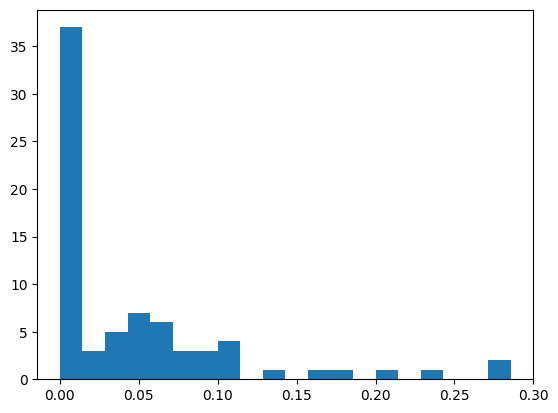

In [170]:
import matplotlib.pyplot as plt

plt.hist(percent_change, bins=20)

In [147]:
from ete3 import faces, AttrFace, TreeStyle, NodeStyle

met_positions = ["LL", "RE", "RW", "M1", "M2", "Liv"]
colors = ["Pink", "Salmon", "Crimson", "LawnGreen", "LimeGreen", "DodgerBlue"]

postion_to_style = {}

for i, pos in enumerate(met_positions):
    postion_to_style[pos] = NodeStyle()
    postion_to_style[pos]["fgcolor"] = colors[i]
    # postion_to_style[pos]["size"] = 50
    postion_to_style[pos]["vt_line_color"] = colors[i]
    postion_to_style[pos]["hz_line_color"] = colors[i]
    postion_to_style[pos]["hz_line_width"] = 15
    postion_to_style[pos]["vt_line_width"] = 15

In [24]:
trees[1][0].root

'0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0'

In [172]:
ete_styled_trees = {}

def cass_to_ete3(tree: CassiopeiaTree, cass_t: CassiopeiaTree) -> Tree:
    t = Tree(f'{tree.root};', format=1)
    # t.add_child(name = tree.root)
    n = Tree()
    for parent, child in tree.breadth_first_traverse_edges():
        if n.name != parent:
            n = t.search_nodes(name=parent)[0]
            try:
                node_location = cass_t.get_attribute(parent, 'met_location')
            except:
                node_location = parent.split('.')[0]
            print(node_location)
            n.set_style(postion_to_style[node_location])
        n.add_child(name=child)
        if tree.is_leaf(child):
            try:
                node_location = cass_t.get_attribute(child, 'met_location')
            except:
                node_location = child.split('.')[0]
            n.search_nodes(name=child)[0].set_style(postion_to_style[node_location])
    return t

for key, val in trees.items():
    # if key != 7:
    #     continue
    cass_t:CassiopeiaTree = val[0]
    cass_t_resolved:CassiopeiaTree = val[1]
    # t = Tree(cass_t.get_newick(), format=1)
    # t_resolved = Tree(cass_t_resolved.get_newick(), format=1)
    
    # t_resolved = Tree()
    # t_resolved.add_child(name = cass_t_resolved.root)
    t = cass_to_ete3(cass_t, cass_t)
    t_resolved = cass_to_ete3(cass_t_resolved, cass_t)
    # print(val)
    
    # for node in cass_t_resolved.depth_first_traverse_nodes():
    #     n = t_resolved.search_nodes(name=node)[0]
    #     for child in cass_t_resolved.children(node):
    #         n.add_child(name=child)
    #     try:
    #         node_location = cass_t.get_attribute(node, 'met_location')
    #     except:
    #         node_location = node.split('.')[0]
    #     n.set_style(postion_to_style[node_location])
    ete_styled_trees[key] = (t, t_resolved)

M1
RW
RE
RE
RE
RE
RE
M2
M2
M2
M2
M2
M2
M2
M1
M1
M1
M1
M1
M1
Liv
M2
RE
M1
Liv
RW
M2
M1
RW
M1
M2
M1
RW
M2
RE
RE
M1
M1
RW
M2
Liv
M1
RW
M1
RW
M1
RE
RE
M2
RW
M1
RW
RE
M1
M2
M1
RE
M2
M1
RE
M1
RW
RE
M2
M2
Liv
M2
M1
M1
M1
M1
RW
M2
Liv
M1
M1
Liv
M1
Liv
M1
M1
M1
M1
RE
Liv
M2
M2
M2
M1
Liv
M1
M1
M1
Liv
LL
M1
M1
M2
M2
M1
RW
Liv
M1
M1
M2
M1
M1
RW
M2
M1
M1
Liv
RE
RE
RW
M1
RW
RW
M1
M2
M1
RW
M1
M1
M1
M1
RW
M1
M2
RE
M1
RE
RE
M2
M1
M1
Liv
Liv
M1
M1
RW
RW
M2
RW
M1
M2
M1
M2
M1
M1
M1
M1
RW
M1
RE
M1
M1
M1
RW
RE
RE
M1
M1
M1
M1
M2
M1
M2
M1
RE
M1
M1
M1
M1
M1
RE
M1
LL
LL
M2
M1
RE
RE
M1
M1
M2
LL
M1
M1
M2
M2
RW
M1
M1
M1
M1
M1
M1
M1
RE
M1
RE
RW
M2
M1
M2
M1
M1
M1
RE
M1
M1
RW
RE
M2
M2
M1
M1
RE
RW
M1
RE
M1
M1
Liv
M1
M1
M1
M1
Liv
M1
M1
RW
M1
M1
RE
RE
RW
Liv
Liv
RW
RE
M1
RE
M2
RE
RW
M1
M2
M1
M1
M2
Liv
M1
Liv
Liv
M1
M1
M1
RW
M1
M2
M1
RW
RE
M1
RW
M1
M1
M1
M1
M1
M1
M1
RE
M1
M2
M1
M1
M1
M1
M1
LL
M1
RE
RE
M1
M1
M1
LL
M2
M1
M1
M1
RE
M1
Liv
M1
M1
M1
M1
M1
M1
M1
M1
M1
M1
M1
Liv
M1
M1
M1
M1
M1
M1
M1
M1
RW
M1
M1
Liv
LL
M1
M2
M1
M

In [162]:
def layout(node):
    if node.is_leaf():
        N = AttrFace("name", fsize=5)
        faces.add_face_to_node(N, node, 0, position="aligned")

ts = TreeStyle()
ts.optimal_scale_level = 'full'
ts.guiding_lines_type = 1
# ts.layout_fn = layout
ts.show_leaf_name = False
ts.mode = "c"
ts.root_opening_factor = 1

In [163]:
ete_styled_trees[7][0].render("test.png", w=1700, tree_style=ts)

{'nodes': [[764.328309589201,
   1228.0785647522687,
   765.6555955101543,
   1229.4058506732222,
   0,
   None],
  [1264.1415293107846,
   852.3800203514909,
   1265.2603311633134,
   853.4988222040196,
   1,
   None],
  [1290.7019180095629,
   849.4445222759803,
   1291.812873457602,
   850.5554777240196,
   2,
   None],
  [1313.0816211445547,
   849.4445222759803,
   1314.192576592594,
   850.5554777240196,
   3,
   None],
  [1335.4610873914871,
   849.4445222759803,
   1336.5720428395266,
   850.5554777240196,
   4,
   None],
  [1290.649763982762,
   855.691699431874,
   1291.776356032773,
   856.818291481885,
   5,
   None],
  [1317.2215430880967,
   853.8602409444841,
   1318.3429479377278,
   854.981645794115,
   6,
   None],
  [1339.599968354086,
   854.0717362539875,
   1340.721373203717,
   855.1931411036186,
   7,
   None],
  [1361.978182265006,
   854.2832295660045,
   1363.0995871146367,
   855.4046344156354,
   8,
   None],
  [1317.1536991712699,
   858.2756148443476,
   

In [173]:
for key, val in ete_styled_trees.items():
    
    def layout(node):
        if node.is_leaf():
            N = AttrFace("name", fsize=5)
            faces.add_face_to_node(N, node, 0, position="aligned")

    ts = TreeStyle()
    ts.optimal_scale_level = 'full'
    ts.guiding_lines_type = 1
    # ts.layout_fn = layout
    ts.show_leaf_name = False
    ts.mode = "c"
    ts.root_opening_factor = 1

    val[0].render(f"resolvedtrees/cp{key}_fixed.png", w=1700, tree_style=ts)

    def layout(node):
        if node.is_leaf():
            N = AttrFace("name", fsize=5)
            faces.add_face_to_node(N, node, 0, position="aligned")

    ts = TreeStyle()
    ts.optimal_scale_level = 'full'
    ts.guiding_lines_type = 1
    # ts.layout_fn = layout
    ts.show_leaf_name = False
    ts.mode = "c"
    ts.root_opening_factor = 1
    
    val[1].render(f"resolvedtrees/cp{key}_resolved_fixed.png", w=1700, tree_style=ts)

In [174]:
import pickle

with open('resolvedtrees/resolved_trees_fixed.pkl', 'wb') as f:
    pickle.dump(trees, f)

with open('resolvedtrees/scores_fixed.pkl', 'wb') as f:
    pickle.dump(scores, f)
with open('resolvedtrees/ete_styled_trees_fixed.pkl', 'wb') as f:
    pickle.dump(ete_styled_trees, f)

In [182]:
def compute_sc_met_score(tree: CassiopeiaTree, cass_t: CassiopeiaTree) -> float:
    # compute metastasis score
    
    # total_edges = len(tree.edges)
    # save treemetrate, met_edges, total_edges
    saved_node_info = {}

    # compute TreeMetRate for each subclade

    for node in tree.depth_first_traverse_nodes():
        met_edges = 0
        total_edges = 0
        # check if there is a metastasis event between node and children
        if tree.is_leaf(node):
            saved_node_info[node] = (0, 0, 0)
            continue
        
        try:
            node_location = cass_t.get_attribute(node, 'met_location')
        except:
            node_location = node.split('.')[0]
            saved_node_info[node] = None
            continue
        
        children = tree.children(node)

        for child in children:
            try:
                child_location = cass_t.get_attribute(child, 'met_location')
                met_edges += saved_node_info[child][1]
                total_edges += saved_node_info[child][2] + 1
            except:
                child_location = child.split('.')[0]
                for c2 in tree.children(child):
                    met_edges += saved_node_info[c2][1]
                    total_edges += saved_node_info[c2][2] + 1
            
            if node_location != child_location:
                met_edges += 1
        saved_node_info[node] = (met_edges / total_edges, met_edges, total_edges)
    
    scMetRates = {}
    for node in tree.leaves:
        ancestors = tree.get_all_ancestors(node)
        all_tmrs = [saved_node_info[ancestor][0] for ancestor in ancestors if saved_node_info[ancestor] != None]
        scMetRates[node] = sum(all_tmrs) / len(all_tmrs)

    return scMetRates

In [196]:
scMetRates = {}
for key, val in trees.items():
    # if key != 7:
    #     continue
    cass_t:CassiopeiaTree = val[0]
    cass_t_resolved:CassiopeiaTree = val[1]
    scMetRate = compute_sc_met_score(cass_t, cass_t)
    scMetRate_resolved = compute_sc_met_score(cass_t_resolved, cass_t)
    scMetRates[key] = (scMetRate, scMetRate_resolved)

In [184]:
scMetRates

{7: ({'RE.ACATGGTAGAAGATTC-1': 0.023530832870243285,
   'RE.CACAAACGTGCGATAG-1': 0.023530832870243285,
   'RE.GGATGTTCACAGACAG-1': 0.023530832870243285,
   'RE.CGAGCACAGCTAACAA-1': 0.023530832870243285,
   'RE.CTAGAGTCAGTAAGAT-1': 0.012243989314336599,
   'M1.CTCAGAAGTCTCCATC-1': 0.04641830124094211,
   'RE.TACCTTATCTGACCTC-1': 0.0546851616897195,
   'M2.CTCGTCACATCATCCC-1': 0.0546851616897195,
   'RE.AAGGTTCTCCATGAAC-1': 0.017648124652682465,
   'RE.TCTATTGTCAAGCCTA-1': 0.017648124652682465,
   'RE.AAGCCGCCAGACGTAG-1': 0.017648124652682465,
   'RE.AGAGCGAAGGGTATCG-1': 0.017648124652682465,
   'M2.CCTATTATCTTGCATT-1': 0.05088758839702916,
   'RE.TTAACTCTCCCAGGTG-1': 0.009795191451469279,
   'RE.CGGTTAATCTATCCCG-1': 0.009795191451469279,
   'RE.GTAACGTAGGCAATTA-1': 0.07231955792320417,
   'RE.ACAGCCGTCTGTTGAG-1': 0.07231955792320417,
   'RE.GGCGACTTCTACGAGT-1': 0.0437481293517756,
   'RE.TGAGGGAAGAGGTACC-1': 0.0437481293517756,
   'RE.AGACGTTCATCTCCCA-1': 0.0437481293517756,
   'M2.TCGC

In [188]:
scMetRates_7_resolved = [i for i in scMetRates[7][1].values()]
scMetRates_7 = [i for i in scMetRates[7][0].values()]

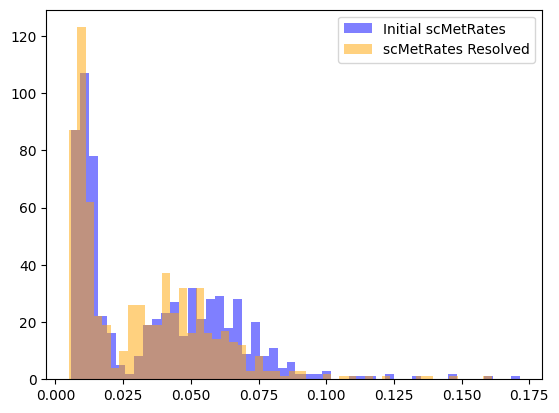

In [214]:
plt.hist(scMetRates_7, bins=50, alpha=0.5, 
         label='Initial scMetRates', color='blue' 
         ) 
plt.hist(scMetRates_7_resolved, bins=50, alpha=0.5, 
         label='scMetRates Resolved', color='orange')
plt.legend(loc='upper right')
plt.show()

In [197]:
resolved_scMets = []
init_scMets = []
for key, val in scMetRates.items():
    scMetRates_resolved = [i for i in val[1].values()]
    scMetRates_init = [i for i in val[0].values()]
    resolved_scMets.append(scMetRates_resolved)
    init_scMets.append(scMetRates_init)


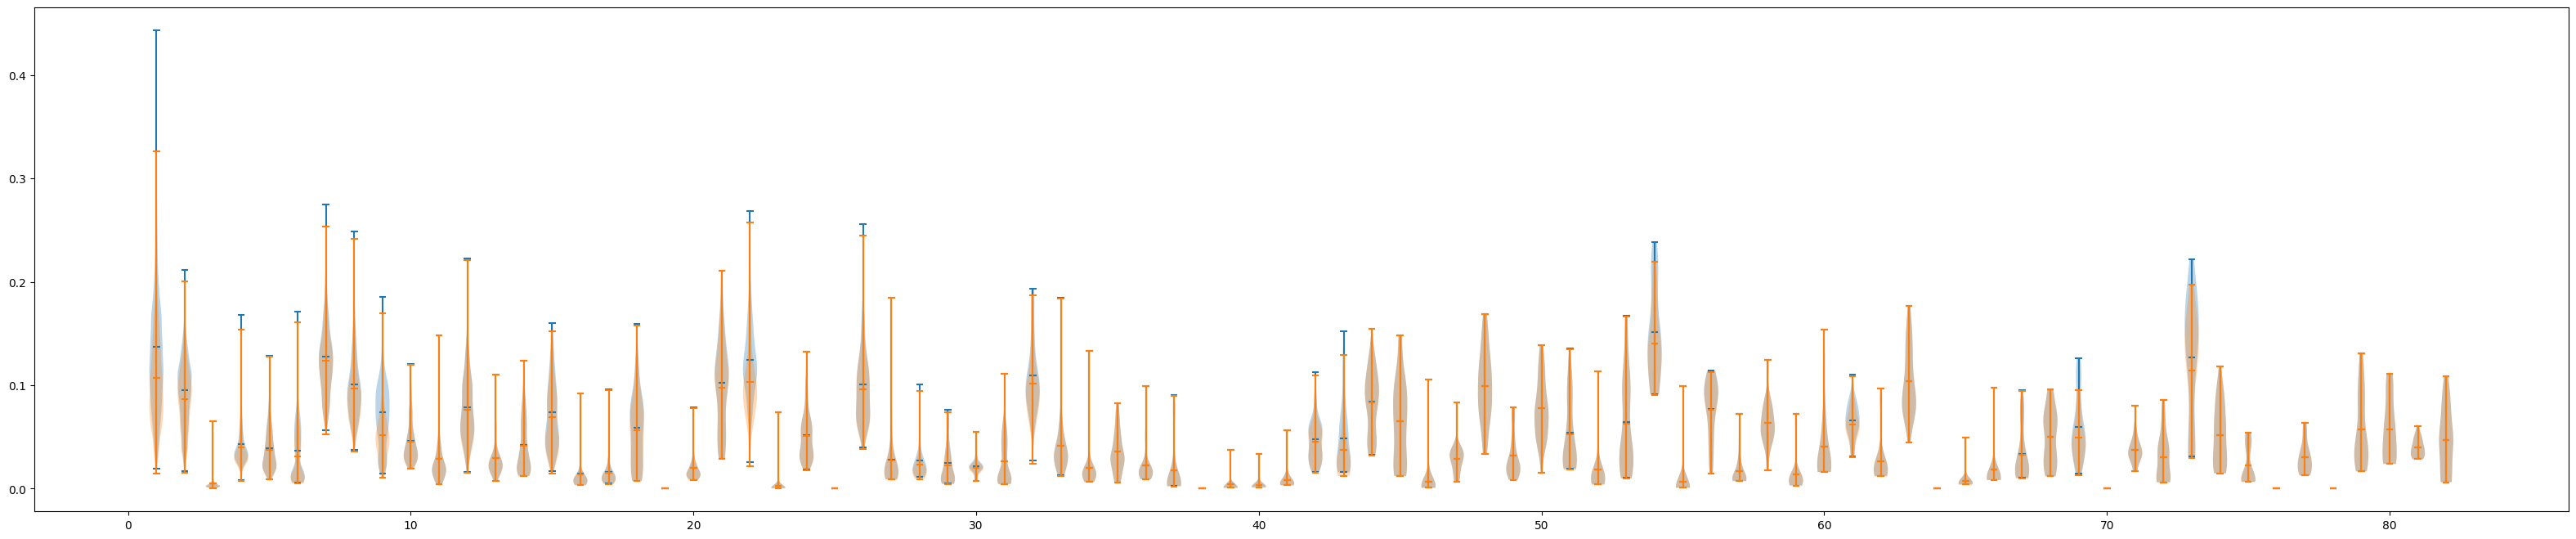

In [205]:
# alpha=0.5,
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(40, 8))

ax1.violinplot(init_scMets,
                  showmeans=True 
         )
plt.violinplot(resolved_scMets,
                  showmeans=True)
# plt.legend(loc='upper right')
plt.show()